In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pycaret.regression import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pandas_profiling
import statsmodels.api as sm

from sklearn.decomposition import PCA

In [2]:
row_data = pd.read_csv('/Users/Desktop/DataCampus/data/final_data/500grid_data.csv')
grid_500 = pd.read_csv('/Users/Desktop/DataCampus/data/final_data/500grid_data.csv')

In [3]:
grid_500['성폭력취약인구'] = grid_500['고등여성인구']+grid_500['20대여성인구']
grid_500['GRADE_폭력'] = grid_500['GRADE_폭력'].apply(lambda x: x-1 if x>0 else x)
grid_500['GRADE_절도'] = grid_500['GRADE_절도'].apply(lambda x: x-1 if x>0 else x)
grid_500['GRADE_성폭력'] = grid_500['GRADE_성폭력'].apply(lambda x: x-1 if x>0 else x)

In [4]:
grid_500['GRADE_폭력'].value_counts()

0     588
1     115
3      53
4      45
5      41
6      27
2      22
7      17
10      5
8       3
9       2
Name: GRADE_폭력, dtype: int64

In [5]:
grid_500['폭력범주']=0
grid_500.loc[grid_500['GRADE_폭력']==0,'폭력범주'] = '폭력없음'
grid_500.loc[(grid_500['GRADE_폭력']>0)&(grid_500['GRADE_폭력']<3),'폭력범주'] = '폭력등급_1'
grid_500.loc[(grid_500['GRADE_폭력']>2)&(grid_500['GRADE_폭력']<5),'폭력범주'] = '폭력등급_2'
grid_500.loc[(grid_500['GRADE_폭력']>4)&(grid_500['GRADE_폭력']<7),'폭력범주'] = '폭력등급_3'
grid_500.loc[(grid_500['GRADE_폭력']>6)&(grid_500['GRADE_폭력']<9),'폭력범주'] = '폭력등급_4'
grid_500.loc[(grid_500['GRADE_폭력']>8)&(grid_500['GRADE_폭력']<11),'폭력범주'] = '폭력등급_5'

In [6]:
numerical_feats = grid_500.dtypes[grid_500.dtypes != "object"].index.tolist()
numerical_feats.remove('INDEX')
numerical_feats.remove('GRADE_폭력')
numerical_feats.remove('GRADE_절도')
numerical_feats.remove('GRADE_성폭력')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = grid_500.dtypes[grid_500.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  3


In [7]:
scaler = StandardScaler()
grid_500[numerical_feats] = scaler.fit_transform(grid_500[numerical_feats])

In [8]:
grid_500.columns

Index(['INDEX', 'ID', '총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '행정동코드', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       'GRADE_폭력', 'GRADE_절도', 'GRADE_성폭력', '성폭력취약인구', '폭력범주'],
      dtype='object')

In [9]:
feature_list = list(grid_500.drop(columns = ['행정동코드','INDEX','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력']).columns)
feature = grid_500[feature_list]
target = grid_500['GRADE_폭력']

In [10]:
selected = grid_500[['총인구', '남성인구', '유소년인구', '35년이상건축물','개별주택가격', '가로등', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포', '룸살롱', '보안등',
          '술집', '원룸_오피스텔', 'cctv','신호등', '횡단보도', '성폭력취약인구']]

In [11]:
x = sm.add_constant(selected, prepend = False)

mnlogit_mod = sm.MNLogit(target, x)
mnlogit_fit = mnlogit_mod.fit(method='bfgs')

print (mnlogit_fit.summary())

         Current function value: 0.712911
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                          MNLogit Regression Results                          
Dep. Variable:               GRADE_폭력   No. Observations:                  918
Model:                        MNLogit   Df Residuals:                      728
Method:                           MLE   Df Model:                          180
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.4617
Time:                        01:12:17   Log-Likelihood:                -654.45
converged:                      False   LL-Null:                       -1215.7
Covariance Type:            nonrobust   LLR p-value:                5.954e-136
 GRADE_폭력=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
총인구            -0.0943     14.449     -0.007      0.995     -28.414      2

In [12]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

ValueError: could not convert string to float: '폭력등급_2'

In [ ]:
from sklearn.metrics import classification_report
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
print(classification_report(target, y_pred))

In [ ]:
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(grid_500)):
    df_train = grid_500.iloc[idx_train]
    df_test = grid_500.iloc[idx_test]
    feature_list = list(grid_500.drop(columns = ['행정동코드','INDEX','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력']).columns)
    feature = df_train[feature_list]
    target = df_train['GRADE_폭력']
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['GRADE_폭력'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

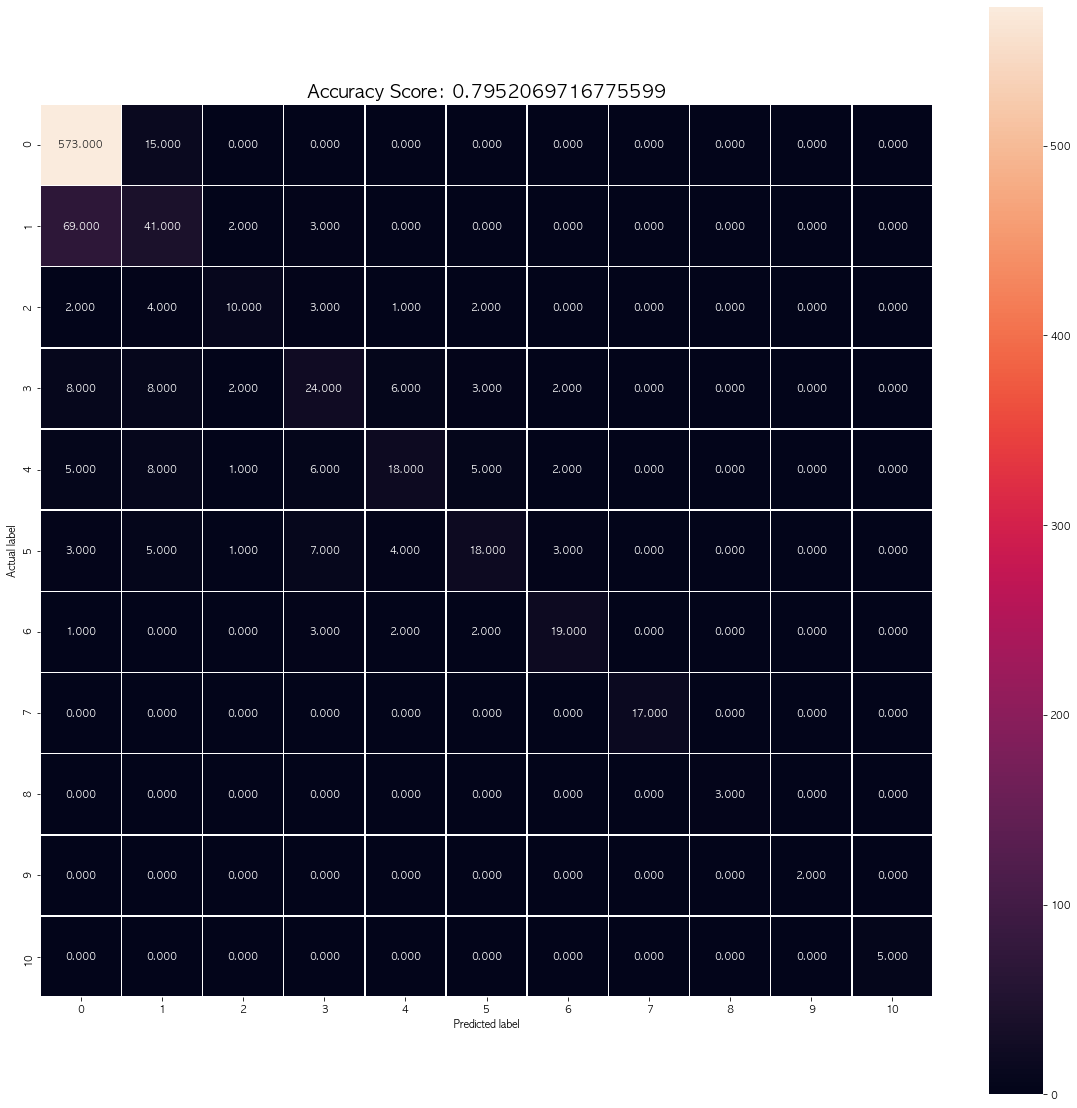

In [188]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

In [189]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.7980652962515115


array([[511,  14,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [ 60,  39,   1,   3,   0,   0,   0,   0,   0,   0,   0],
       [  3,   2,  10,   3,   1,   2,   0,   0,   0,   0,   0],
       [  8,   6,   2,  25,   5,   1,   1,   0,   0,   0,   0],
       [  4,   9,   0,   7,  18,   3,   1,   0,   0,   0,   0],
       [  3,   4,   0,   7,   3,  18,   3,   0,   0,   0,   0],
       [  1,   1,   0,   2,   3,   3,  16,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  15,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5]])

In [190]:
selected_list = list(selected.columns)

In [200]:
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(grid_500)):
    df_train = grid_500.iloc[idx_train]
    df_test = grid_500.iloc[idx_test]
    feature_list = list(selected.columns)
    feature = df_train[feature_list]
    target = df_train['GRADE_폭력']
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['GRADE_폭력'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
scores
scores.mean()

학습 Accuracy = 0.74576271, 검증 Accuracy = 0.72826087
학습 Accuracy = 0.75786925, 검증 Accuracy = 0.75000000
학습 Accuracy = 0.75060533, 검증 Accuracy = 0.67391304
학습 Accuracy = 0.75665860, 검증 Accuracy = 0.73913043
학습 Accuracy = 0.74818402, 검증 Accuracy = 0.65217391
학습 Accuracy = 0.75060533, 검증 Accuracy = 0.67391304
학습 Accuracy = 0.75302663, 검증 Accuracy = 0.68478261
학습 Accuracy = 0.74213075, 검증 Accuracy = 0.66304348
학습 Accuracy = 0.75332527, 검증 Accuracy = 0.60439560
학습 Accuracy = 0.74848851, 검증 Accuracy = 0.73626374


0.6905876731963688

In [192]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [193]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.7484885126964933


array([[510,  14,   0,   0,   0,   2,   0,   0,   0,   0,   0],
       [ 72,  24,   2,   4,   1,   0,   0,   0,   0,   0,   0],
       [  1,   6,  10,   4,   0,   0,   0,   0,   0,   0,   0],
       [ 10,   6,   2,  21,   6,   1,   2,   0,   0,   0,   0],
       [  7,   4,   3,   9,  10,   6,   3,   0,   0,   0,   0],
       [  2,   6,   0,   7,   4,  16,   3,   0,   0,   0,   0],
       [  1,   1,   0,   4,   6,   5,   9,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   1,   1,  12,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5]])

In [55]:
mod_prob = OrderedModel(target,
                        feature,
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.865721
         Iterations: 119
         Function evaluations: 121
         Gradient evaluations: 121


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               GRADE_폭력   Log-Likelihood:                -794.73
Model:                   OrderedModel   AIC:                             1685.
Method:            Maximum Likelihood   BIC:                             1917.
Date:                Wed, 18 Aug 2021                                         
Time:                        22:20:08                                         
No. Observations:                 918                                         
Df Residuals:                     870                                         
Df Model:                          48                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
총인구               0.4832     51.501      0.009      0.993    -100.456     101.423
남성인구              3.1462     25.064      0.126      0.900     -45.978      52.270
여성인구             -2.0348     26.486     -0.077      0.939     -53.947      49.878
고등여성인구           -0.0976     22.845     -0.004      0.997     -44.874      44.678
20대여성인구          -0.3788     86.680     -0.004      0.997    -170.269     169.511
유소년인구            -0.5813      0.308     -1.885      0.059      -1.186       0.023
고령인구              0.1629      0.295      0.551      0.582      -0.416       0.742
30년이상35년미만건축물    -0.0094      0.044     -0.213      0.831      -0.096       0.077
35년이상건축물          0.1490      0.065      2.310      0.021       0.023       0.275
개별주택가격            0.4811      0.057      8.438      0.000       0.369       0.593
공시지가              0.1521      0.090      1.684      0.092      -0.025       0.329
가로등               0.2000      0.074      2.708      0.007       0.055       0.345
공영주차장             0.0122      0.047      0.262      0.794      -0.079       0.104
공중화장실             0.1039      0.047      2.205      0.027       0.012       0.196
교육시설             -0.0263      0.083     -0.316      0.752      -0.189       0.137
교통사고_19           0.1336      0.072      1.850      0.064      -0.008       0.275
교통사고_20          -0.0716      0.042     -1.707      0.088      -0.154       0.011
노숙인시설             0.0577      0.036      1.589      0.112      -0.013       0.129
대규모점포            -0.0694      0.048     -1.445      0.149      -0.164       0.025
대부업현황            -0.0213      0.044     -0.483      0.629      -0.108       0.065
룸살롱               0.1189      0.061      1.964      0.050       0.000       0.238
버스정류장             0.0721      0.065      1.116      0.265      -0.055       0.199
보안등              -0.2650      0.055     -4.847      0.000      -0.372      -0.158
상가               -0.0526      0.107     -0.490      0.624      -0.263       0.158
숙박업소             -0.0444      0.054     -0.822      0.411      -0.150       0.061
술집                0.3583      0.122      2.940      0.003       0.119       0.597
어린이보호             0.0698      0.051      1.368      0.171      -0.030       0.170
어린이집              0.0014      0.072      0.019      0.985      -0.140       0.143
오락시설              0.0912      2.997      0.030      0.976      -5.783       5.965
원룸_오피스텔          -0.1833      0.068     -2.713      0.007      -0.316      -0.051
유흥시설             -0.1194     35.229     -0.003      0.997     -69.166      68.927
음식점              -0.1373     32.632     -0.004      0.997     -64.094      63.820
자율방범대            -0.0545      0.045     -1.217      0.223      -0.142       0.033
파출소              -0.0133      0.039     -0.337      0.736      -0.090       0.064
cctv              0.2827      0.088      3.213      0.001       0.110       0.455
신호등              -0.1257      0.077     -1.637

In [57]:
num_of_thresholds = 9
mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])

array([       -inf, -0.18584671,  0.03621574,  0.60594837,  1.17726699,
        1.8800353 ,  2.64340806,  3.62884007,  4.00096932,  4.43267569,
               inf])

In [58]:
mod_prob = OrderedModel(target,
                        feature,
                        distr='logit')

res_prob = mod_prob.fit(method='bfgs', disp=False)
res_prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               GRADE_폭력   Log-Likelihood:                -789.57
Model:                   OrderedModel   AIC:                             1675.
Method:            Maximum Likelihood   BIC:                             1907.
Date:                Wed, 18 Aug 2021                                         
Time:                        22:25:20                                         
No. Observations:                 918                                         
Df Residuals:                     870                                         
Df Model:                          48                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
총인구               0.9996        nan        nan        nan         nan         nan
남성인구              5.5355        nan        nan        nan         nan         nan
여성인구             -3.3376        nan        nan        nan         nan         nan
고등여성인구           -0.1807        nan        nan        nan         nan         nan
20대여성인구          -0.7821        nan        nan        nan         nan         nan
유소년인구            -1.1088        nan        nan        nan         nan         nan
고령인구              0.2939        nan        nan        nan         nan         nan
30년이상35년미만건축물    -0.0574        nan        nan        nan         nan         nan
35년이상건축물          0.2967        nan        nan        nan         nan         nan
개별주택가격            0.8327        nan        nan        nan         nan         nan
공시지가              0.2437        nan        nan        nan         nan         nan
가로등               0.3486        nan        nan        nan         nan         nan
공영주차장             0.0187        nan        nan        nan         nan         nan
공중화장실             0.1901        nan        nan        nan         nan         nan
교육시설             -0.0589        nan        nan        nan         nan         nan
교통사고_19           0.3096        nan        nan        nan         nan         nan
교통사고_20          -0.1355        nan        nan        nan         nan         nan
노숙인시설             0.0718        nan        nan        nan         nan         nan
대규모점포            -0.1110        nan        nan        nan         nan         nan
대부업현황            -0.0165        nan        nan        nan         nan         nan
룸살롱               0.2092        nan        nan        nan         nan         nan
버스정류장             0.0441        nan        nan        nan         nan         nan
보안등              -0.5155        nan        nan        nan         nan         nan
상가               -0.1520        nan        nan        nan         nan         nan
숙박업소             -0.0978        nan        nan        nan         nan         nan
술집                0.6337        nan        nan        nan         nan         nan
어린이보호             0.1441        nan        nan        nan         nan         nan
어린이집              0.0075        nan        nan        nan         nan         nan
오락시설              0.1233        nan        nan        nan         nan         nan
원룸_오피스텔          -0.3210        nan        nan        nan         nan         nan
유흥시설             -0.1304        nan        nan        nan         nan         nan
음식점              -0.1521        nan        nan        nan         nan         nan
자율방범대            -0.1133        nan        nan        nan         nan         nan
파출소              -0.0142        nan        nan        nan         nan         nan
cctv              0.5387        nan        nan        nan         nan         nan
신호등              -0.2246        nan        nan

In [62]:
predicted = res_log.model.predict(res_log.params, exog=feature)
predicted

NameError: name 'res_log' is not defined

In [63]:
res_log

NameError: name 'res_log' is not defined